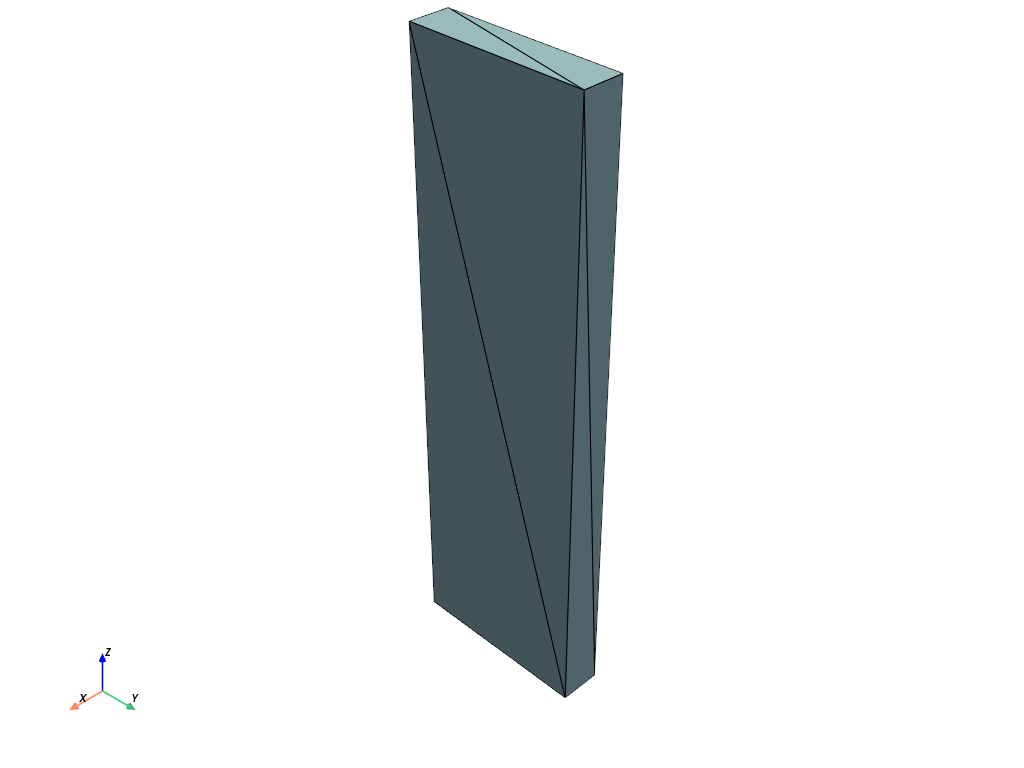

In [11]:
import pyvista as pv
import tetgen
import warnings

# Load surface model (e.g., .stl, .obj, .ply)
surface_mesh = pv.read('mesh.stl')

tgen = tetgen.TetGen(surface_mesh)

nodes, elems = tgen.tetrahedralize(switches="pq1.1/10Y")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    tgen.grid.plot(show_edges=True)
      
tgen.write("grid.vtk", binary=True)

In [12]:
# Initialize Gmsh
gmsh.initialize()

# Define path to STL file
stl_file = "mesh.stl"

# Define parameters
mesh_size = 0.1

# Merge the STL mesh
gmsh.merge(stl_file)

# Create a mesh
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), mesh_size)
gmsh.model.mesh.generate(3)

# Save mesh as MSH file
output_mesh_file = "output_mesh.msh"
gmsh.write(output_mesh_file)

# Finalize Gmsh
gmsh.finalize()


Delaunizing vertices...
Delaunay seconds:  5.6e-05
Creating surface mesh ...
Surface mesh seconds:  1.8e-05
Recovering boundaries...
Boundary recovery seconds:  0.000315
Removing exterior tetrahedra ...
Exterior tets removal seconds:  5e-06
Suppressing Steiner points ...
Steiner suppression seconds:  1e-06
Recovering Delaunayness...
Delaunay recovery seconds:  4.7e-05
Refining mesh...
  11 insertions, added 0 points, 1 tetrahedra in queue.
  3 insertions, added 0 points, 0 tetrahedra in queue.
  4 insertions, added 0 points, 0 tetrahedra in queue.
  5 insertions, added 1 points, 4 tetrahedra in queue.
  7 insertions, added 0 points, 0 tetrahedra in queue.
Refinement seconds:  4.7e-05
Smoothing vertices...
Mesh smoothing seconds:  0.000158
Improving mesh...
Mesh improvement seconds:  9e-06

Writing nodes.
Writing elements.
Writing faces.
Writing edges.

Output seconds:  5e-06
Total running seconds:  0.000849

Statistics:

  Input points: 8
  Input facets: 12
  Input segments: 18
  Input

In [13]:
import gmsh
import math
import os
import sys

gmsh.initialize()

def createGeometryAndMesh():
    gmsh.clear()
    # Get the current working directory
    cwd = os.getcwd()
    # Path to the STL file (assuming it's in the same directory as the script)
    stl_file_path = os.path.join(cwd, 'mesh.stl')
    gmsh.merge(stl_file_path)

    angle = gmsh.onelab.getNumber('Parameters/Angle for surface detection')[0]
    forceParametrizablePatches = gmsh.onelab.getNumber('Parameters/Create surfaces guaranteed to be parametrizable')[0]
    includeBoundary = True
    curveAngle = 180

    gmsh.model.mesh.classifySurfaces(angle * math.pi / 180., includeBoundary, forceParametrizablePatches, curveAngle * math.pi / 180.)
    gmsh.model.mesh.createGeometry()

    s = gmsh.model.getEntities(2)
    l = gmsh.model.geo.addSurfaceLoop([e[1] for e in s])
    gmsh.model.geo.addVolume([l])
    gmsh.model.geo.synchronize()

    f = gmsh.model.mesh.field.add("MathEval")
    if gmsh.onelab.getNumber('Parameters/Apply funny mesh size field?')[0]:
        gmsh.model.mesh.field.setString(f, "F", "2*Sin((x+y)/5) + 3")
    else:
        gmsh.model.mesh.field.setString(f, "F", "4")
    gmsh.model.mesh.field.setAsBackgroundMesh(f)

    gmsh.model.mesh.generate(3)
    gmsh.write('remeshed.msh')

# Create ONELAB parameters with remeshing options:
gmsh.onelab.set("""[
  {
    "type":"number",
    "name":"Parameters/Angle for surface detection",
    "values":[40],
    "min":20,
    "max":120,
    "step":1
  },
  {
    "type":"number",
    "name":"Parameters/Create surfaces guaranteed to be parametrizable",
    "values":[0],
    "choices":[0, 1]
  },
  {
    "type":"number",
    "name":"Parameters/Apply funny mesh size field?",
    "values":[0],
    "choices":[0, 1]
  }
]""")

# Create the geometry and mesh it:
createGeometryAndMesh()

# Launch the GUI and handle the "check" event to recreate the geometry and mesh
# with new parameters if necessary:
def checkForEvent():
    action = gmsh.onelab.getString("ONELAB/Action")
    if len(action) and action[0] == "check":
        gmsh.onelab.setString("ONELAB/Action", [""])
        createGeometryAndMesh()
        gmsh.graphics.draw()
    return True

if "-nopopup" not in sys.argv:
    gmsh.fltk.initialize()
    while gmsh.fltk.isAvailable() and checkForEvent():
        gmsh.fltk.wait()

gmsh.finalize()


Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reading '/home/osquel/research/mesh.stl'...
Info    : Mesh is in binary format
Info    : 12 facets in solid 0 Exported from Blender-3.0.1
Info    : Done reading '/home/osquel/research/mesh.stl'
Info    : Classifying surfaces (angle: 40)...
Info    : Found 6 model surfaces
Info    : Found 12 model curves
Info    : Done classifying surfaces (Wall 0.000161346s, CPU 0.000138s)
Info    : Creating geometry of discrete curves...
Info    : Done creating geometry of discrete curves (Wall 4.366e-06s, CPU 5e-06s)
Info    : Creating geometry of discrete surfaces...
Info    : [  0%] Discrete surface 2 is planar, simplifying parametrization
Info    : [ 20%] Discrete surface 3 is planar, simplifying parametrization
Info    : [ 40%] Discrete surface 4 is planar, simplifying parametrization
Info    : [ 50%] Discrete surface 5 is planar, simplifying parametrization
Info    : [ 70%] Discrete surface 6 is pla

In [1]:
# ------------------------------------------------------------------------------
#
#  Gmsh Python tutorial 6
#
#  Transfinite meshes, deleting entities
#
# ------------------------------------------------------------------------------

import gmsh
import math
import sys

gmsh.initialize()

gmsh.model.add("t6")

# Copied from `t1.py'...
lc = 1e-2
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(.1, 0, 0, lc, 2)
gmsh.model.geo.addPoint(.1, .3, 0, lc, 3)
gmsh.model.geo.addPoint(0, .3, 0, lc, 4)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(3, 2, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
gmsh.model.geo.addCurveLoop([4, 1, -2, 3], 1)
gmsh.model.geo.addPlaneSurface([1], 1)

# Delete the surface and the left line, and replace the line with 3 new ones:
gmsh.model.geo.remove([(2, 1), (1, 4)])

p1 = gmsh.model.geo.addPoint(-0.05, 0.05, 0, lc)
p2 = gmsh.model.geo.addPoint(-0.05, 0.1, 0, lc)
l1 = gmsh.model.geo.addLine(1, p1)
l2 = gmsh.model.geo.addLine(p1, p2)
l3 = gmsh.model.geo.addLine(p2, 4)

# Create surface
gmsh.model.geo.addCurveLoop([2, -1, l1, l2, l3, -3], 2)
gmsh.model.geo.addPlaneSurface([-2], 1)

# The `setTransfiniteCurve()' meshing constraints explicitly specifies the
# location of the nodes on the curve. For example, the following command forces
# 20 uniformly placed nodes on curve 2 (including the nodes on the two end
# points):
gmsh.model.geo.mesh.setTransfiniteCurve(2, 20)

# Let's put 20 points total on combination of curves `l1', `l2' and `l3' (beware
# that the points `p1' and `p2' are shared by the curves, so we do not create 6
# + 6 + 10 = 22 nodes, but 20!)
gmsh.model.geo.mesh.setTransfiniteCurve(l1, 6)
gmsh.model.geo.mesh.setTransfiniteCurve(l2, 6)
gmsh.model.geo.mesh.setTransfiniteCurve(l3, 10)

# Finally, we put 30 nodes following a geometric progression on curve 1
# (reversed) and on curve 3: Put 30 points following a geometric progression
gmsh.model.geo.mesh.setTransfiniteCurve(1, 30, "Progression", -1.2)
gmsh.model.geo.mesh.setTransfiniteCurve(3, 30, "Progression", 1.2)

# The `setTransfiniteSurface()' meshing constraint uses a transfinite
# interpolation algorithm in the parametric plane of the surface to connect the
# nodes on the boundary using a structured grid. If the surface has more than 4
# corner points, the corners of the transfinite interpolation have to be
# specified by hand:
gmsh.model.geo.mesh.setTransfiniteSurface(1, "Left", [1, 2, 3, 4])

# To create quadrangles instead of triangles, one can use the `setRecombine'
# constraint:
gmsh.model.geo.mesh.setRecombine(2, 1)

# When the surface has only 3 or 4 points on its boundary the list of corners
# can be omitted in the `setTransfiniteSurface()' call:
gmsh.model.geo.addPoint(0.2, 0.2, 0, 1.0, 7)
gmsh.model.geo.addPoint(0.2, 0.1, 0, 1.0, 8)
gmsh.model.geo.addPoint(0, 0.3, 0, 1.0, 9)
gmsh.model.geo.addPoint(0.25, 0.2, 0, 1.0, 10)
gmsh.model.geo.addPoint(0.3, 0.1, 0, 1.0, 11)
gmsh.model.geo.addLine(8, 11, 10)
gmsh.model.geo.addLine(11, 10, 11)
gmsh.model.geo.addLine(10, 7, 12)
gmsh.model.geo.addLine(7, 8, 13)
gmsh.model.geo.addCurveLoop([13, 10, 11, 12], 14)
gmsh.model.geo.addPlaneSurface([14], 15)
for i in range(10, 14):
    gmsh.model.geo.mesh.setTransfiniteCurve(i, 10)
gmsh.model.geo.mesh.setTransfiniteSurface(15)

# The way triangles are generated can be controlled by specifying "Left",
# "Right" or "Alternate" in `setTransfiniteSurface()' command. Try e.g.
#
# gmsh.model.geo.mesh.setTransfiniteSurface(15, "Alternate")

gmsh.model.geo.synchronize()

# Finally we apply an elliptic smoother to the grid to have a more regular
# mesh:
gmsh.option.setNumber("Mesh.Smoothing", 100)

gmsh.model.mesh.generate(2)
gmsh.write("t6.msh")

# Launch the GUI to see the results:
if '-nopopup' not in sys.argv:
    gmsh.fltk.run()

gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Line)
Info    : Done meshing 1D (Wall 0.000543367s, CPU 0.002697s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 50%] Meshing surface 15 (Transfinite)
Info    : Done meshing 2D (Wall 0.000892967s, CPU 0.002955s)
Info    : 701 nodes 856 elements
Info    : Writing 't6.msh'...
Info    : Done writing 't6.msh'
-------------------------------------------------------
Version       : 4.12.2
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240121
Build host    : gmsh.info
Build options : 64Bit ALGLIB[co